In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
from halomod import halo_model
from halomod.fort.routines import hod_routines as fort
from scipy.integrate import trapz,simps

In [11]:
h = halo_model.HaloModel(rnum=50,halo_exclusion="NgMatched")

## P(k) 1h s-s

#### FORTRAN

In [4]:
def fortran_pk_1h_ss():
    ## USE FORTRAN
    u = h.profile.u(h.k, h.M, norm='m')
    p = fort.power_gal_1h_ss(nlnk=len(h.k),
                             nm=len(h.M),
                             u=np.asfortranarray(u),
                             dndm=h.dndm.value,
                             nsat=h.n_sat,
                             ncen=h.n_cen,
                             mass=h.M.value,
                             central=h.hod._central)
    return p

In [5]:
%timeit fortran_pk_1h_ss()

The slowest run took 53.20 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 63.7 ms per loop


#### Python

In [6]:
def python_pk_1h_ss():
    u = h.profile.u(h.k, h.M, norm='m')
    integ = u**2 * h.dndm * h.M * h.n_sat**2
    if h.hod._central:
        integ *= h.n_cen

    p = trapz(integ,dx=h.dlog10m*np.log(10))
    return p

In [7]:
%timeit python_pk_1h_ss()

10 loops, best of 3: 70.7 ms per loop


#### Test Equivalence

In [8]:
ratio = python_pk_1h_ss()/fortran_pk_1h_ss()
print ratio.min(), ratio.max(), nanmean(ratio)

0.998889847714 h3 / Mpc3 1.00147130351 h3 / Mpc3 1.00000033314 h3 / Mpc3


## xi(r) 1h cs

#### FORTRAN

In [9]:
def fortran_xir_1h_cs():
    rho = h.profile.rho(h.r, h.M, norm="m")
    c = fort.corr_gal_1h_cs(nr=len(h.r),
                        nm=len(h.M),
                        r=h.r.value,
                        mass=h.M.value,
                        dndm=h.dndm.value,
                        ncen=h.n_cen,
                        nsat=h.n_sat,
                        rho=np.asfortranarray(rho),
                        mean_dens=h.mean_density0.value,
                        delta_halo=h.delta_halo) * h.mean_gal_den.unit ** 2
    return c

In [10]:
%timeit fortran_xir_1h_cs()

The slowest run took 13.38 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 2.24 ms per loop


#### Python

In [11]:
def python_xir_1h_cs():
    rho = h.profile.rho(h.r, h.M, norm="m")
    mmin = 4*np.pi * h.r**3 * h.mean_density * h.delta_halo/3
    mask = np.repeat(h.M,len(h.r)).reshape(len(h.M),len(h.r)) < mmin
    integ = h.dndm * 2 * h.n_cen * h.n_sat * rho * h.M
    integ[mask.T] = 0
    return trapz(integ,dx=h.dlog10m*np.log(10))

In [12]:
%timeit python_xir_1h_cs()

100 loops, best of 3: 4 ms per loop


#### Test Equivalence

In [13]:
ratio = python_xir_1h_cs()/fortran_xir_1h_cs()
print nanmin(ratio), nanmax(ratio), nanmean(ratio)

0.75021624166 1.49997868046 1.01344529707


/Users/Steven/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:785: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self, other)


## xi(r) 1h Total

#### FORTRAN

In [12]:
def fortran_xir_1h():        
    rho = h.profile.rho(h.r, h.M, norm="m")
    lam = h.profile.lam(h.r, h.M, norm="m")
    c = fort.corr_gal_1h(nr=len(h.r),
                         nm=len(h.M),
                         r=h.r.value,
                         mass=h.M.value,
                         dndm=h.dndm.value,
                         ncen=h.n_cen,
                         nsat=h.n_sat,
                         rho=np.asfortranarray(rho),
                         lam=np.asfortranarray(lam),
                         central=h.hod._central,
                         mean_dens=h.mean_density0.value,
                         delta_halo=h.delta_halo) * h.mean_gal_den.unit ** 2
    return c

In [13]:
%timeit fortran_xir_1h()

The slowest run took 389.03 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 8.4 ms per loop


#### Python

In [14]:
def python_xir_1h(): 
    rho = h.profile.rho(h.r, h.M, norm="m")
    lam = h.profile.lam(h.r, h.M, norm="m")
    
    integ = h.dndm * h.n_sat**2 * lam
    if h.hod._central:
        integ *= h.n_cen

    mmin = 4*np.pi*h.r**3*h.mean_density*h.delta_halo/3
    mask = np.repeat(h.M,len(h.r)).reshape(len(h.M),len(h.r)) > mmin
    #print np.sum(mask,axis=0)
    integ2 = h.dndm*2 * h.n_cen*h.n_sat*rho
    integ[mask.T] += integ2[mask.T]

    integ *= h.M

    c = simps(integ,dx=h.dlog10m*np.log(10))
    return c

In [15]:
%timeit python_xir_1h()

100 loops, best of 3: 10.9 ms per loop


#### Test Equivalence

In [16]:
ratio = python_xir_1h()/fortran_xir_1h()
print nanmin(ratio), nanmax(ratio), nanmean(ratio)

0.752327444668 Mpc6 / h6 1.49993765741 Mpc6 / h6 1.01073095601 Mpc6 / h6


/Users/Steven/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:802: RuntimeWarning: invalid value encountered in divide
  return np.divide(other, self)


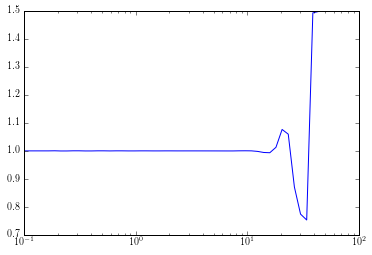

In [17]:
plot(h.r,ratio)
xscale('log')

(1e-05, 100.0)

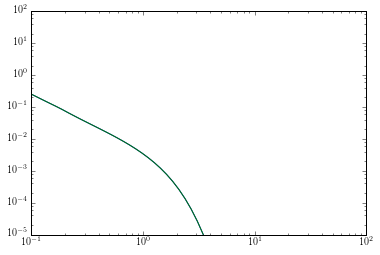

In [19]:
plot(h.r,python_xir_1h())
plot(h.r,fortran_xir_1h())
xscale('log')
yscale('log')
ylim((1e-5,100.0))

## Two-halo Term

In [8]:
from halomod.twohalo_wrapper import twohalo_wrapper as thalo
def fortran_2halo():       
    u = h.profile.u(h.k, h.M , norm='m')
    return thalo("ng_matched", True,
                 h.M.value, h.bias, h.n_tot,
                 h.dndm.value, np.log(h.k.value),
                 h._power_halo_centres.value, u, h.r.value, h.corr_mm_base,
                 h.mean_gal_den.value, h.delta_halo,
                 h.mean_density.value, h.nthreads_2halo)
    

In [11]:
%timeit fortran_2halo()

10 loops, best of 3: 76.3 ms per loop


In [4]:
from halomod import tools
def python_2halo():
    ### POWER PART
    u = h.profile.u(h.k,h.M,norm="m")
    if h.scale_dependent_bias is not None:
        bias = np.outer(h.sd_bias.bias_scale(),h.bias)
    else:
        bias = h.bias
    inst = h.halo_exclusion(m=h.M,density=h.n_tot*h.dndm,
                            I=h.n_tot*h.dndm*u/h.mean_gal_den,
                            bias=bias,r=h.r,delta_halo=h.delta_halo,
                            mean_density=h.mean_density)

    if hasattr(inst,"density_mod"):
        __density_mod = inst.density_mod
    else:
        __density_mod = h.mean_gal_den

    power_gg_2h= inst.integrate() * h._power_halo_centres

    if len(power_gg_2h.shape)==2:
        corr = tools.power_to_corr_ogata_matrix(power_gg_2h,h.k.value,h.r)
    else:
        corr = tools.power_to_corr_ogata(power_gg_2h,h.k.value,h.r)

    ## modify by the new density
    return (__density_mod/h.mean_gal_den)**2 * (1+corr)-1

In [10]:
%timeit python_2halo()

1 loops, best of 3: 1.97 s per loop


### Equivalence Test

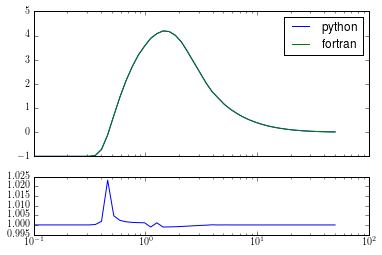

In [11]:
py = python_2halo()
fort = fortran_2halo()

fig,ax = plt.subplots(2,1,sharex=True,subplot_kw={"xscale":"log"},gridspec_kw={"height_ratios":(2.5,1)})
ax[0].plot(h.r,py,label="python")
ax[0].plot(h.r,fort,label="fortran")
#ax[0].plot(r,anl,label="analytic")
ax[0].legend(loc=0)

ax[1].plot(h.r,py/fort)

## Matter 2-halo

In [6]:
def python_m_2halo():
    u = h.profile.u(h.k,h.M,norm="m")
    if h.scale_dependent_bias is not None:
        bias = np.outer(h.sd_bias.bias_scale(),h.bias)
    else:
        bias = h.bias
    inst = h.halo_exclusion(m=h.M,density=h.dndlnm,
                            I=h.dndlnm*u/h.rho_gtm[0],
                            bias=bias,r=h.r,delta_halo=h.delta_halo,
                            mean_density=h.mean_density)

    if hasattr(inst,"density_mod"):
        __density_mod = inst.density_mod
    else:
        __density_mod = h.rho_gtm[0]

    power_mm_2h= inst.integrate() * h._power_halo_centres

    if len(power_mm_2h.shape)==2:
        corr = tools.power_to_corr_ogata_matrix(power_mm_2h,h.k.value,h.r)
    else:
        corr = tools.power_to_corr_ogata(power_mm_2h,h.k.value,h.r)

    ## modify by the new density
    return (__density_mod/h.mean_desnity)**2 * (1+corr)-1

For the matter power, it makes more sense to integrate to smaller values of M_min, and we want the overall integrated effective bias to be consistent, so we use the Tinker10 pairing of $n(m)$ and $b(m)$. For comparison purposes, we use the method of Schneider+12.

1.0
0.872657860541


(1e-05, 100000.0)

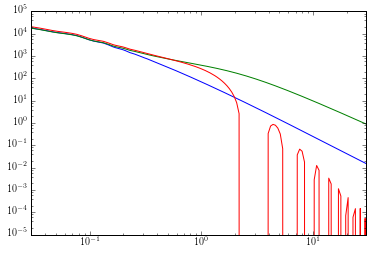

In [8]:
h = halo_model.HaloModel(rnum=50,hod_params={"M_min":1.0},mf_fit="Tinker10",bias_model="Tinker10",
                         halo_exclusion="NoExclusion",_hc_spectrum="filtered-nl",scale_dependent_bias=None)

print log10(h.M[0].value)
print h.bias_effective_matter
plot(h.k,h.power)
plot(h.k,h.nonlinear_power)
plot(h.k,h.power_mm_2h)
xscale('log')
yscale('log')
xlim((0.03,30.0))
ylim((1e-5,1e5))


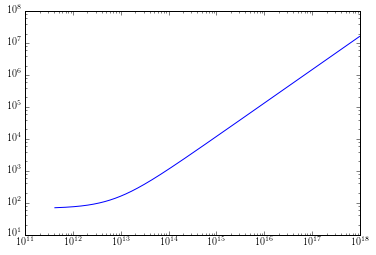

In [16]:
plot(h.M,h.n_tot/h.mean_gal_den)
xscale('log')
yscale('log')

In [17]:
h.bias_effective

<Quantity 1.1091056234026908>

In [18]:
h.bias_effective_matter

<Quantity 1.5626403431065163>

In [ ]:
h.